# <center> BLG 527E Machine Learning Homework 2

## Question 1

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [19]:
SEED = 42

In [123]:
# Given mean and variance matricies
mu1 = np.array([1, 2])
mu2 = np.array([3, 5])
sigma1 = np.array([[2, 1], [1, 3]])
sigma2 = np.array([[1, -0.8], [-0.8, 3]])

### 1.a - Dataset Generation

In [124]:
# Random dataset generation
np.random.seed(SEED)

# Generate Features
X1 = np.random.multivariate_normal(mu1, sigma1, 1000)
X2 = np.random.multivariate_normal(mu2, sigma2, 1000)

# Class Labels
y1 = np.zeros(1000)
y2 = np.ones(1000)

# Combine Datasets
X = np.vstack((X1, X2))
y = np.hstack((y1, y2))

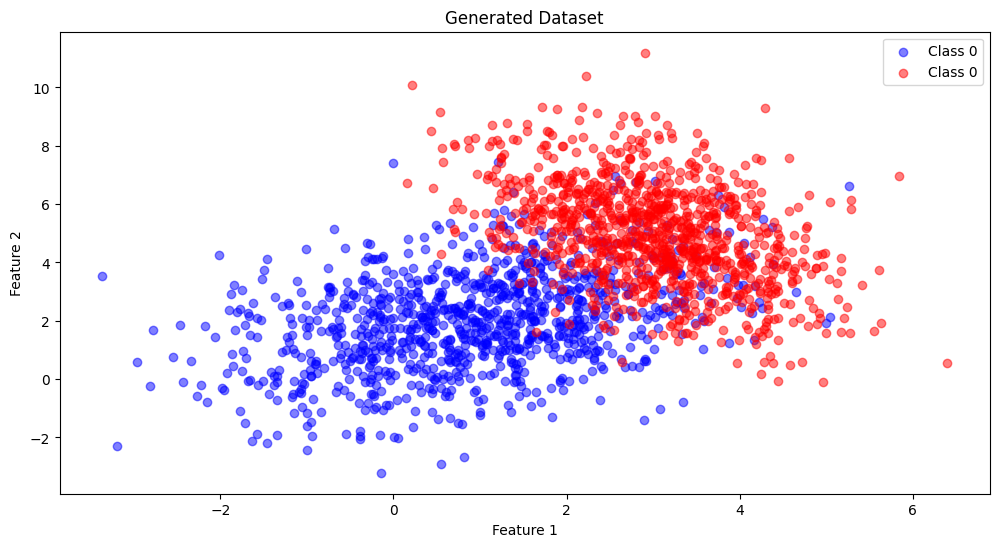

In [163]:
# Data Visualization
plt.figure(figsize=(12, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='blue', label='Class 0', alpha=0.5)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='red', label='Class 0', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Generated Dataset')
plt.legend()
plt.show()

### 1.b - Train-Test Split and Mean, Covariance Calculation

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Equations from the book. Implementation will be based on these equatinos.

1. $ E[\mathbf{x}] = \boldsymbol{\mu} = [\mu_1, \ldots, \mu_d]^T $

2. $ \sigma_{ij} \equiv \text{Cov}(X_i, X_j) = E[(X_i - \mu_i)(X_j - \mu_j)] = E[X_i X_j] - \mu_i \mu_j $

3. $ \Sigma \equiv \text{Cov}(\mathbf{X}) = E[(\mathbf{X} - \boldsymbol{\mu})(\mathbf{X} - \boldsymbol{\mu})^T] = E[\mathbf{XX}^T] - \boldsymbol{\mu}\boldsymbol{\mu}^T $ 

In [167]:
def mean(X, y=None, class_label=None):
    if class_label:
        X = X[y==class_label]
    mu = np.sum(X, axis=0) / X.shape[0]
    return np.reshape(mu, (1, -1)) 

def covariance(X, mean_vector, y=None, class_label=None):
    if class_label:
        X = X[y==class_label]
    X_c = X - mean_vector
    return X_c.T @ X_c / X.shape[0]

In [152]:
X_train_mu_0 = mean(X_train, y_train, 0)
X_train_mu_1 = mean(X_train, y_train, 1)

In [153]:
X_train_cov_0 = covariance(X_train, X_train_mu_0, y_train, 0)
X_train_cov_1 = covariance(X_train, X_train_mu_1, y_train, 1)

In [154]:
X_train_cov_0

array([[1.96356387, 0.8652446 ],
       [0.8652446 , 2.80115573]])

### 1.c - Quadratic Discriminant Classifier

In [155]:
class QDA:
    def __init__(self, mean_vectors: dict, cov_matrices: dict):
        self.mean_vectors = mean_vectors
        self.cov_matrices = cov_matrices
        self.classes = mean_vectors.keys()
        self.priors = None

    def fit(self, X_train, y_train):
        self.priors = {c: np.mean(y_train == c) for c in self.classes}
    
    def predict(self, X):
        probabilities = np.array([
            self._calculate_probability(X, c) for c in self.classes
        ]).T
        return np.argmax(probabilities, axis=1)
    
    def _calculate_probability(self, X, class_label):
        mean_vec = self.mean_vectors[class_label]
        cov_mat = self.cov_matrices[class_label]
        inv_cov_mat = np.linalg.inv(cov_mat)
        det_cov_mat = np.linalg.det(cov_mat)
        
        diff = X - mean_vec
        exponent = -0.5 * np.sum(diff @ inv_cov_mat * diff, axis=1)
        prefactor = 1 / np.sqrt((2 * np.pi) ** X.shape[1] * det_cov_mat)
        
        return prefactor * np.exp(exponent) * self.priors[class_label]

In [156]:
mean_vectors = {0: X_train_mu_0, 1: X_train_mu_1}
cov_matrices = {0: X_train_cov_0, 1: X_train_cov_1}

qda_model = QDA(mean_vectors, cov_matrices)
qda_model.fit(X_train, y_train)


In [157]:
# Obtain the training and test errors
y_train_pred = qda_model.predict(X_train)
y_test_pred = qda_model.predict(X_test)

train_error_qda = np.mean(y_train_pred != y_train)
test_error_qda = np.mean(y_test_pred != y_test)

train_error_qda, test_error_qda

(0.09125, 0.09)

In [158]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [159]:
Z_qda = qda_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z_qda = Z_qda.reshape(xx.shape)

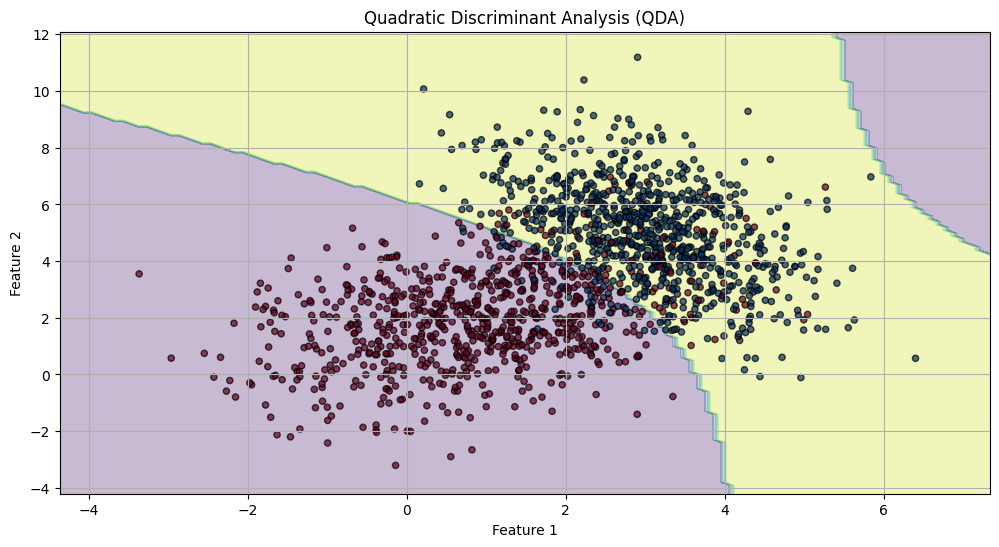

In [162]:
plt.figure(figsize=(12, 6))
plt.contourf(xx, yy, Z_qda, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolor='k', s=20, alpha=0.7)
plt.title('Quadratic Discriminant Analysis (QDA)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)

### 1.d - Lineer Discriminant Analysis

In [171]:
class LDA:
    def __init__(self, mean_vectors, shared_cov_matrix):
        self.mean_vectors = mean_vectors
        self.shared_cov_matrix = shared_cov_matrix
        self.priors = None

    def fit(self, X_train, y_train):
        classes = np.unique(y_train)
        self.priors = {c: np.mean(y_train == c) for c in classes}
    
    def predict(self, X):
        probabilities = np.array([
            self._calculate_probability(X, c) for c in [0, 1]
        ]).T
        return np.argmax(probabilities, axis=1)
    
    def _calculate_probability(self, X, class_label):
        mean_vec = self.mean_vectors[class_label]
        inv_shared_cov_matrix = np.linalg.inv(self.shared_cov_matrix)
        
        diff = X - mean_vec
        exponent = -0.5 * np.sum(diff @ inv_shared_cov_matrix * diff, axis=1)
        prefactor = np.exp(exponent) * self.priors[class_label]
        
        return prefactor


In [172]:
lda_model = LDA(mean_vectors, covariance(X_train, mean(X_train)))
lda_model.fit(X_train, y_train)

In [173]:
y_train_pred_lda = lda_model.predict(X_train)
y_test_pred_lda = lda_model.predict(X_test)

train_error_lda = np.mean(y_train_pred_lda != y_train)
test_error_lda = np.mean(y_test_pred_lda != y_test)

train_error_lda, test_error_lda

(0.10125, 0.09)

In [174]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [175]:
Z_lda = lda_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z_lda = Z_lda.reshape(xx.shape)

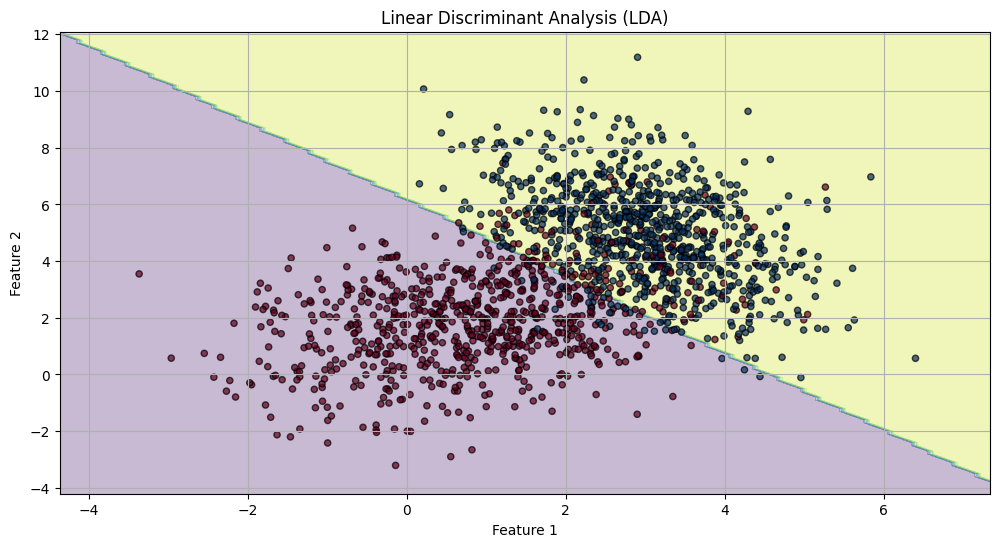

In [176]:
plt.figure(figsize=(12, 6))
plt.contourf(xx, yy, Z_lda, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolor='k', s=20, alpha=0.7)
plt.title('Linear Discriminant Analysis (LDA)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)